In [4]:
import pandas as pd 
import numpy as np
import torch 
import torch.nn as nn 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset , DataLoader

In [5]:
df = pd.read_csv("OMC_CSV_final.csv" , sep=';')
df["Date"] = pd.to_datetime(df["Date"],dayfirst=True)
df["Call Drop Rate"] = pd.to_numeric(df["Call Drop Rate"] , errors="coerce")
df["SDCCH drop rate  "] = pd.to_numeric(df["SDCCH drop rate  "] , errors="coerce")
df["SDCCH cong rate"] = pd.to_numeric(df["SDCCH cong rate"] , errors="coerce")
print(f"Max CDR : ",max(df["Call Drop Rate"]))
print(f"Min CDR : ",min(df["Call Drop Rate"]))


Max CDR :  1.0
Min CDR :  0.0


In [6]:
from sklearn.preprocessing import RobustScaler
import numpy as np
site_names =  df["Site"].unique().tolist()
cell_names = df["Cell"].unique().tolist()
print(len(site_names))
print(len(cell_names))
site_to_id = {name:idx for idx,name in enumerate(site_names)}
cell_to_id = {name:idx for idx,name in enumerate(cell_names)}
seq_len = 15
features_cols = ["Call Drop Rate", "SDCCH drop rate  ","SDCCH cong rate", "RTCH Assignment Fail Rate"]

# 1. Fit scalers globally (on the full dataset)
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit on all feature data (excluding Date, Site, Cell)
scaler_x.fit(df[features_cols].values)
scaler_y.fit(df[["Call Drop Rate"]].values)

all_seq = []

for site in site_names:
    site_df = df[df["Site"] == site].sort_values("Date")
    site_df = site_df[["Date","Cell"] + features_cols].dropna()
    cells_in_site = site_df["Cell"].unique()
    
    for cell in cells_in_site:
        cell_df = site_df[site_df["Cell"] == cell]

        if len(cell_df) < seq_len + 1:
            continue
        
        # Apply the global scaler
        features = scaler_x.transform(cell_df[features_cols].astype(float).values)
        cdr = scaler_y.transform(cell_df[["Call Drop Rate"]].astype(float).values).flatten()
        
        for i in range(len(features) - seq_len):
            x = features[i:i+seq_len]
            y = cdr[i + seq_len]
            
            site_id = site_to_id[site]
            cell_id = cell_to_id[cell]
            
            all_seq.append((x, site_id, cell_id, y))

print(f"Total sequences: {len(all_seq)}")


## Aggregation : 

X_list = []
y_list = []

for seq, site_id, cell_id, y in all_seq:
    # seq is shape (seq_len, 3)
    agg_features = []
    for col_idx in range(seq.shape[1]):
        agg_features += [
            seq[:, col_idx].mean(),
            seq[:, col_idx].std(),
            seq[:, col_idx].min(),
            seq[:, col_idx].max(),
            seq[-1, col_idx]  # last value
        ]
    # Add site_id and cell_id
    agg_features += [site_id, cell_id]
    
    X_list.append(agg_features)
    y_list.append(y)

X = np.array(X_list)
y = np.array(y_list)

print(f"X shape: {X.shape}, y shape: {y.shape}")


515
2004
Total sequences: 54018
X shape: (54018, 22), y shape: (54018,)


In [7]:
from xgboost import XGBRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , r2_score

In [8]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [43]:
model = XGBRegressor(
    n_estimators = 1000,
    learning_rate=0.05,
    max_depth = 15,
    subsample=1,
    colsample_bytree = 0.1,
    random_state=42
)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
r2 = r2_score(y_test,y_pred)
print(f"RMSE : {rmse}  --  r2 : {r2}")

RMSE : 0.01643913794102004  --  r2 : 0.36398852286371497


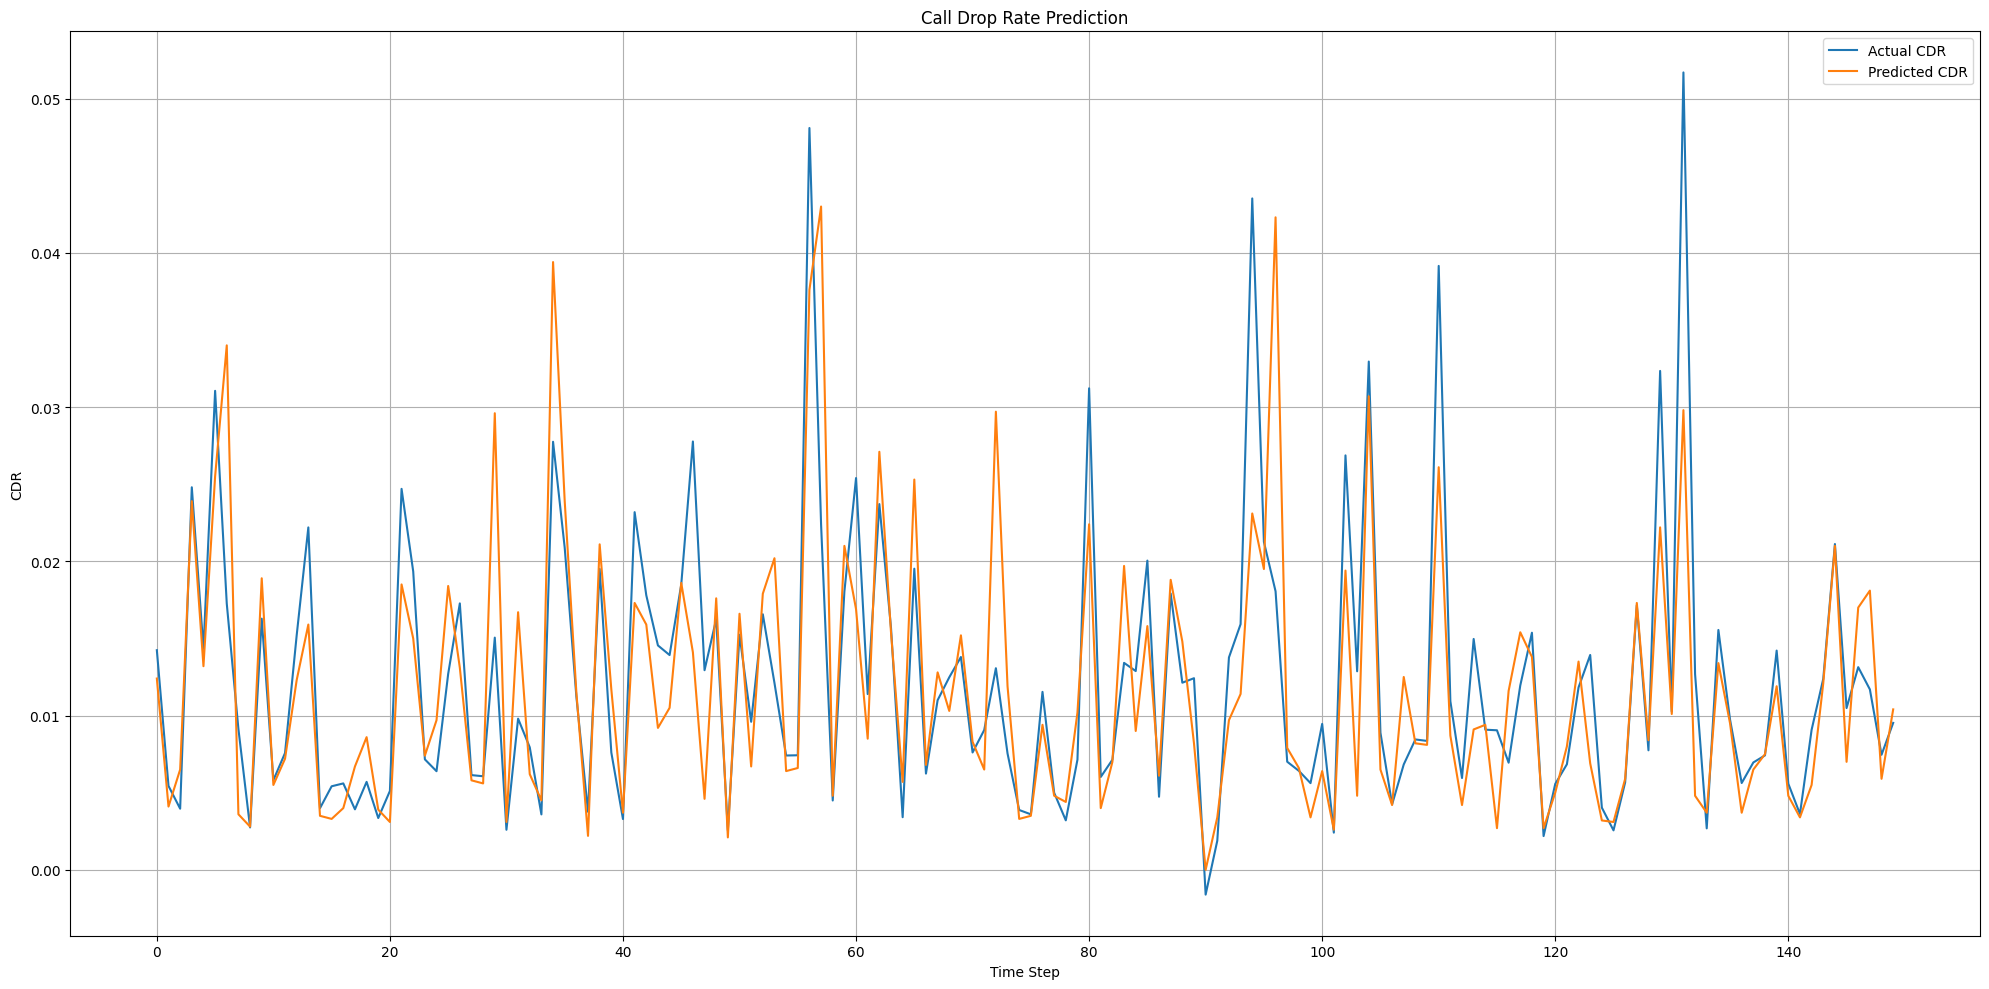

In [44]:
plt.figure(figsize=(20, 10))
plt.plot(y_pred[:150], label="Actual CDR")
plt.plot(y_test[:150], label="Predicted CDR")
plt.legend()
plt.title("Call Drop Rate Prediction")
plt.xlabel("Time Step")
plt.ylabel("CDR")
plt.grid(True)
plt.tight_layout()
plt.show() 

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
RMSE: 0.0157, R²: 0.4220


<Figure size 1000x600 with 0 Axes>

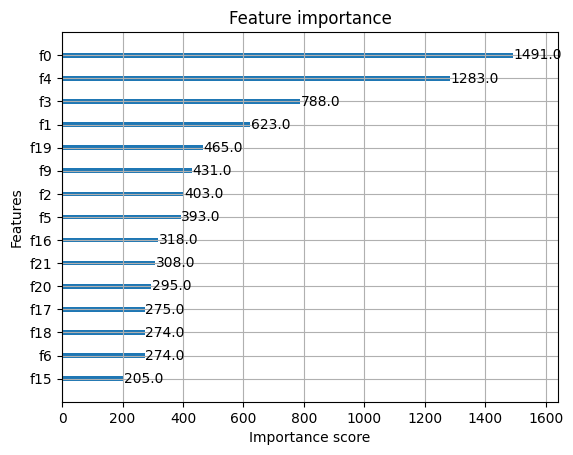

In [45]:
param_grid = {
    'n_estimators': [300, 1000],
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 10],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb_model = XGBRegressor(random_state=42)
grid = GridSearchCV(xgb_model, param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)
grid.fit(x_train, y_train)

print(f"Best Params: {grid.best_params_}")

# ======================
# 6. Final Model Training
# ======================
best_model = grid.best_estimator_
y_pred_new = best_model.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_new))
r2 = r2_score(y_test, y_pred_new)
print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")

# ======================
# 7. Feature Importance
# ======================
plt.figure(figsize=(10, 6))
from xgboost import plot_importance
plot_importance(best_model, importance_type='weight', max_num_features=15)
plt.show()


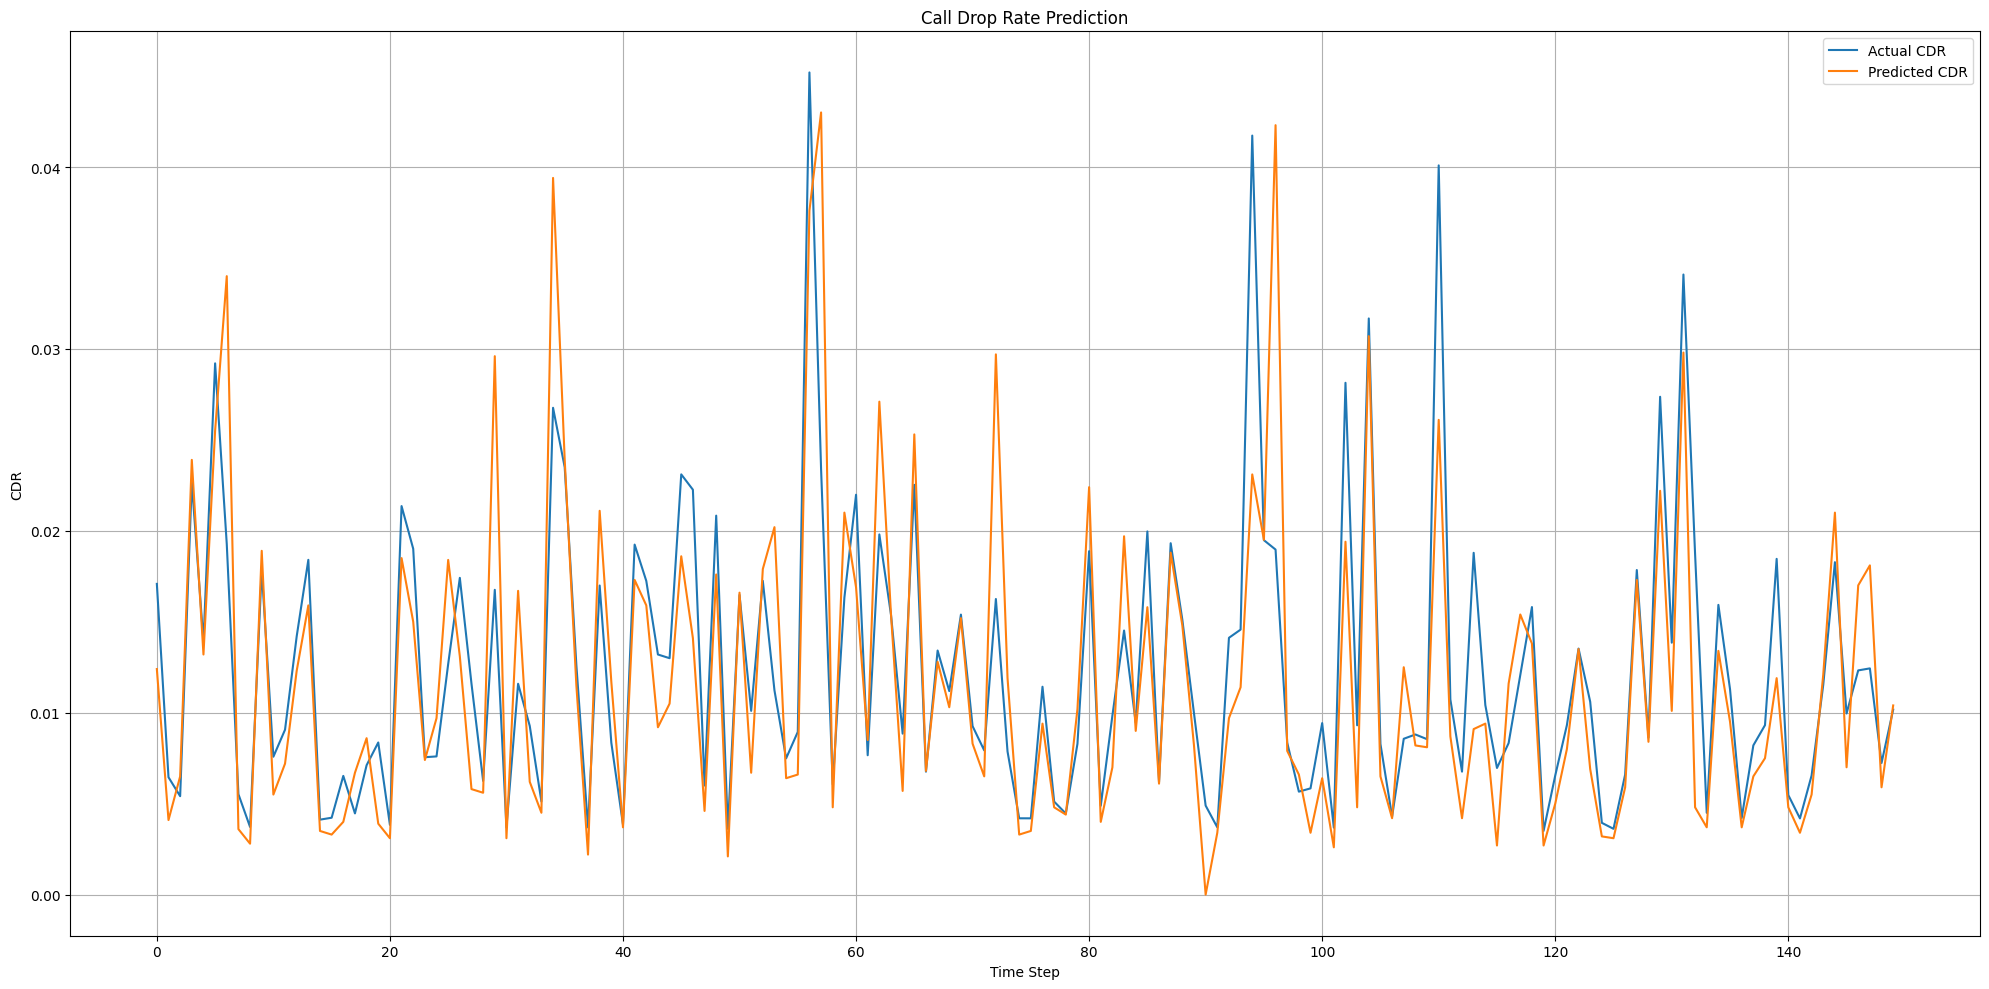

In [50]:
plt.figure(figsize=(20, 10))
plt.plot(y_pred_new[:150], label="Actual CDR")
plt.plot(y_test[:150], label="Predicted CDR")
plt.legend()
plt.title("Call Drop Rate Prediction")
plt.xlabel("Time Step")
plt.ylabel("CDR")
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
forecast_results = []
for site in site_names:
    site_df = df[df["Site"] == site].sort_values("Date")
    for cell in site_df["Cell"].unique():
        cell_df = site_df[site_df["Cell"] == cell]
        if len(cell_df) < seq_len:
            continue
        
        features = scaler_x.transform(cell_df[features_cols].values[-seq_len:])
        agg_features = []
        for col_idx in range(features.shape[1]):
            agg_features += [
                features[:, col_idx].mean(),
                features[:, col_idx].std(),
                features[:, col_idx].min(),
                features[:, col_idx].max(),
                features[-1, col_idx]
            ]
        agg_features += [site_to_id[site], cell_to_id[cell]]
        pred_scaled = best_model.predict(np.array(agg_features).reshape(1, -1))[0]
        pred_cdr = scaler_y.inverse_transform([[pred_scaled]])[0][0]
        forecast_results.append((site, cell, pred_cdr))

print(f"Forecasted {len(forecast_results)} cell predictions")

Forecasted 1999 cell predictions


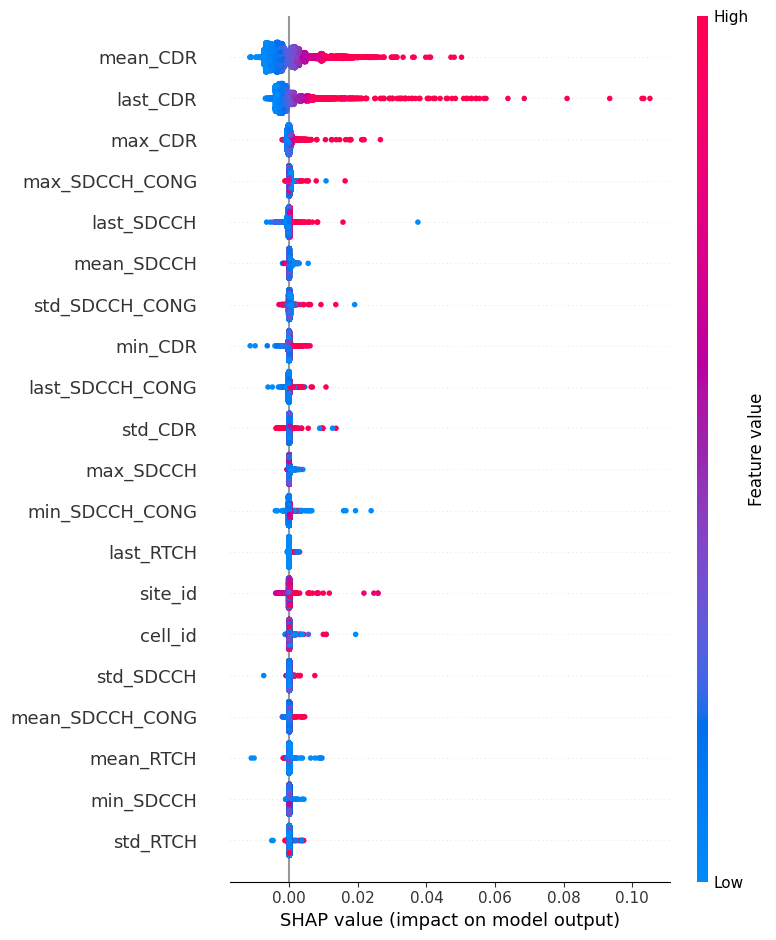

In [48]:
import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(x_test)

# Summary plot
shap.summary_plot(shap_values, x_test, feature_names=[
    'mean_CDR','std_CDR','min_CDR','max_CDR','last_CDR',
    'mean_SDCCH','std_SDCCH','min_SDCCH','max_SDCCH','last_SDCCH',
    'mean_RTCH','std_RTCH','min_RTCH','max_RTCH','last_RTCH',
    'mean_SDCCH_CONG','std_SDCCH_CONG','min_SDCCH_CONG','max_SDCCH_CONG','last_SDCCH_CONG',
    'site_id','cell_id'
])


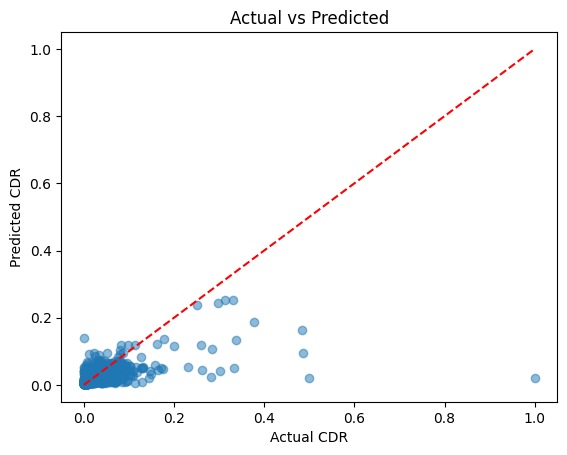

In [55]:
plt.scatter(y_test, y_pred_new, alpha=0.5)
plt.xlabel("Actual CDR")
plt.ylabel("Predicted CDR")
plt.title("Actual vs Predicted")
plt.plot([min(y_test), max(y_test)],
         [min(y_test), max(y_test)],
         'r--')
plt.show()